In [11]:
import os
import json
import os 
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
#Data is uploaded to google drive. Connecting colab to the drive to fetch data.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
json_1 = '/content/drive/MyDrive/sarcasm_data.json'

def load_json(jfile):
    data = []
    with open(jfile) as f:
        for line in f.readlines():
            j = json.loads(line)
            url, headline, sarcastic = j['article_link'], j['headline'], j['is_sarcastic']
            data.append([url, headline, sarcastic])
    return pd.DataFrame(data, columns=['article_link', 'headline', 'is_sarcastic'])

df = load_json(json_1)
df.head(5)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
#Exploring the dataset.
df['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

<Axes: xlabel='is_sarcastic', ylabel='count'>

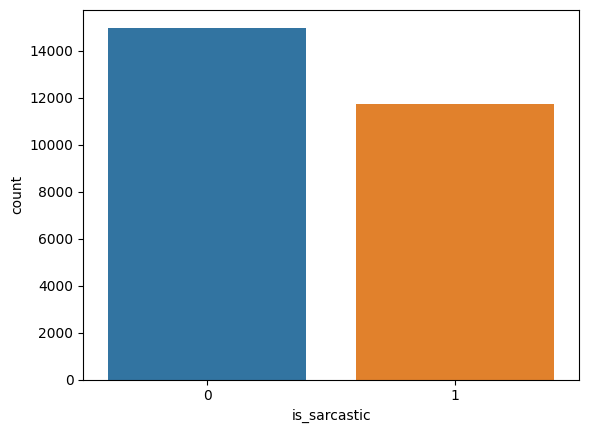

In [5]:
sbs.countplot(x='is_sarcastic',data=df)

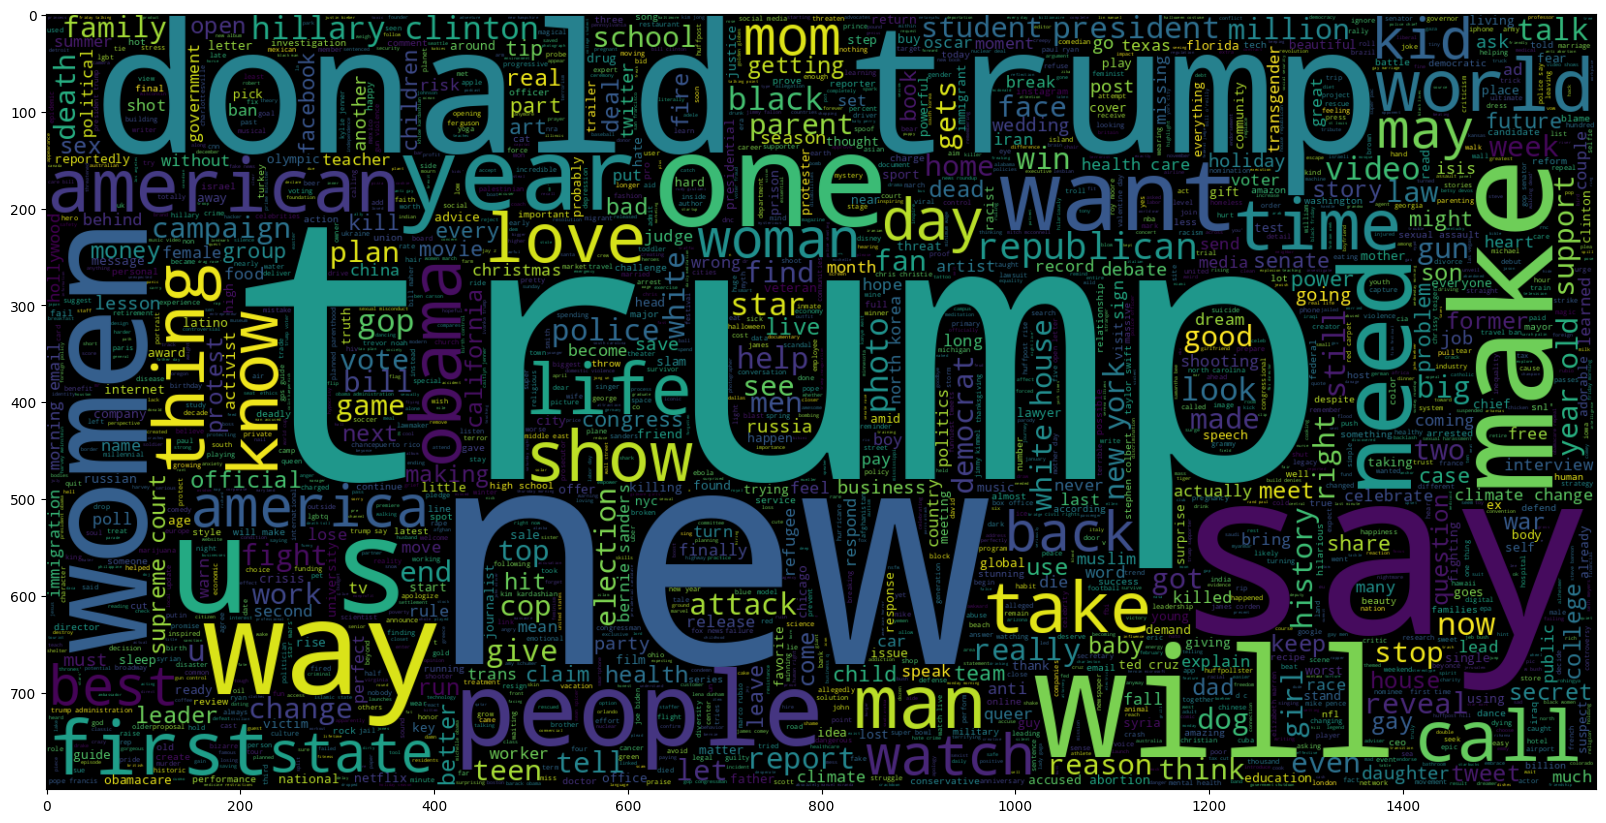

In [6]:
#WORDCLOUD for non-sarcastic tweets

from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

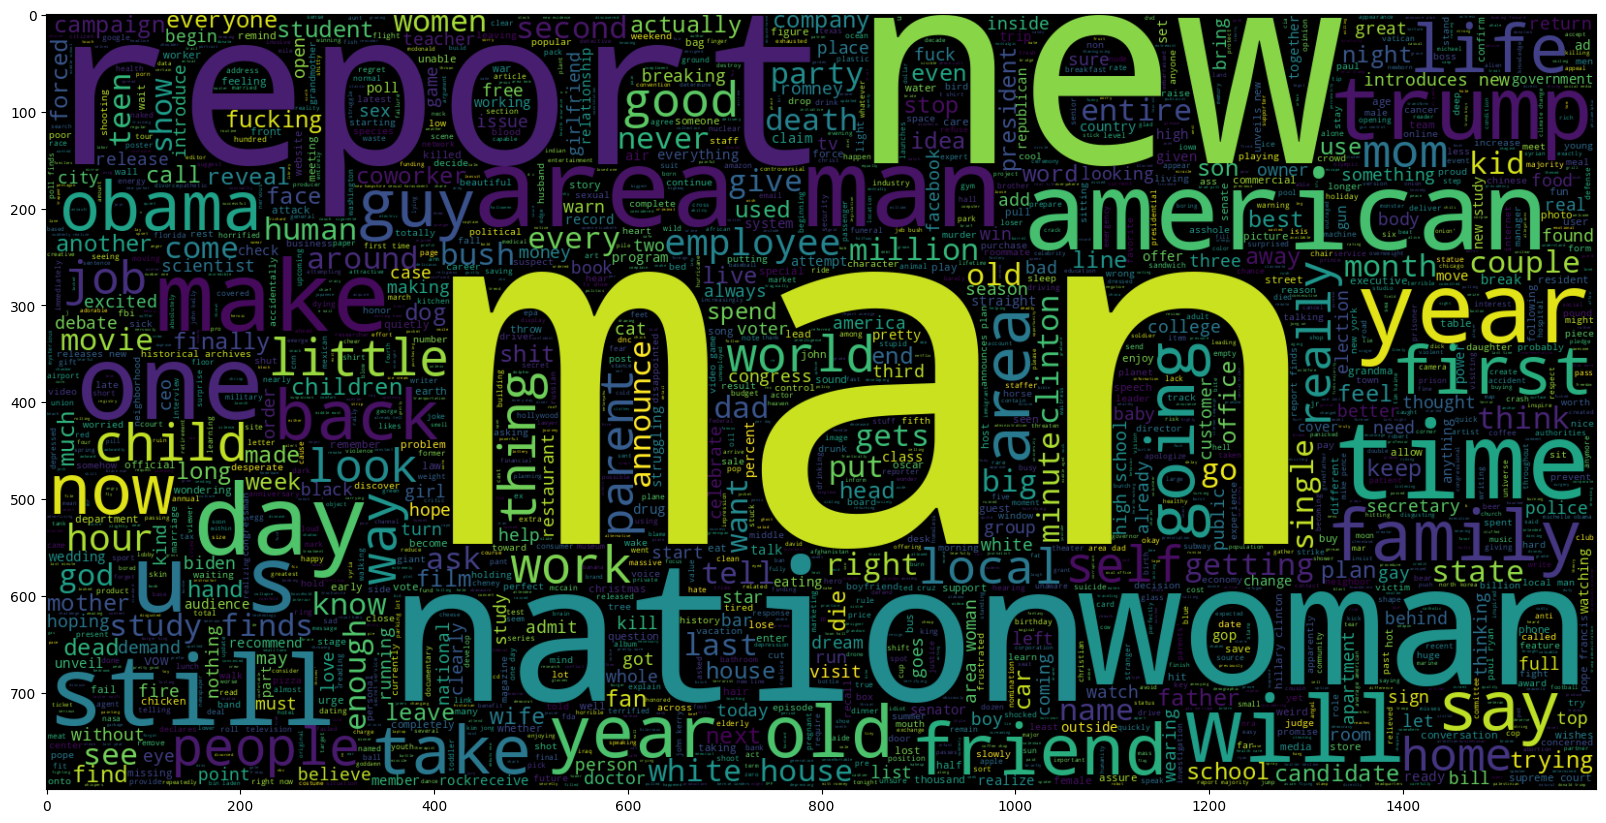

In [7]:
#WPRDCLOUD for sarcastic tweets

plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

In [15]:
# Split data into training and testing datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Extract text and labels from the data
train_texts = train_df['headline'].values
train_labels = train_df['is_sarcastic'].values
test_texts = test_df['headline'].values
test_labels = test_df['is_sarcastic'].values

In [16]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on training texts and transform them to numerical features
train_features = vectorizer.fit_transform(train_texts)

# Transform the testing texts to numerical features using the fitted vectorizer
test_features = vectorizer.transform(test_texts)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(train_features, train_labels)

# Make predictions on the testing set
predictions = classifier.predict(test_features)

# Evaluate the classifier
accuracy = accuracy_score(test_labels, predictions)
report = classification_report(test_labels, predictions)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.8446274803444402
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2996
           1       0.83      0.82      0.82      2346

    accuracy                           0.84      5342
   macro avg       0.84      0.84      0.84      5342
weighted avg       0.84      0.84      0.84      5342



In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad the sequences to have the same length
max_sequence_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

In [19]:
# Define the LSTM RNN model
lstm_model = Sequential()
lstm_model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
lstm_model.add(LSTM(80))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           2653600   
                                                                 
 lstm (LSTM)                 (None, 80)                57920     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 2,711,601
Trainable params: 2,711,601
Non-trainable params: 0
_________________________________________________________________


In [13]:
es = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/lstm-rnn.h5",
    monitor= "val_accuracy",
    verbose= 1,
    save_best_only= True,
    save_weights_only= False,
    save_freq="epoch"
)

history_lstm_rnn = lstm_model.fit(train_sequences, train_labels, batch_size=32, epochs=10, validation_data=(test_sequences, test_labels),callbacks=[es,model_checkpoint])

Epoch 1/10
668/668 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.7747
Epoch 1: val_accuracy improved from -inf to 0.85530, saving model to /content/drive/MyDrive/lstm-rnn.h5
668/668 [==============================] - 35s 40ms/step - loss: 0.4546 - accuracy: 0.7747 - val_loss: 0.3646 - val_accuracy: 0.8553
Epoch 2/10
668/668 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9213
Epoch 2: val_accuracy did not improve from 0.85530
668/668 [==============================] - 7s 10ms/step - loss: 0.2103 - accuracy: 0.9213 - val_loss: 0.3348 - val_accuracy: 0.8540
Epoch 3/10
668/668 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9628
Epoch 3: val_accuracy did not improve from 0.85530
668/668 [==============================] - 7s 10ms/step - loss: 0.1125 - accuracy: 0.9628 - val_loss: 0.4126 - val_accuracy: 0.8472
Epoch 4/10
668/668 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9803
Epoch 4: val_

In [38]:
lstm_model.load_weights(filepath="/content/drive/MyDrive/lstm-rnn.h5")
output= lstm_model.predict(test_sequences).round()

r = sklearn.metrics.confusion_matrix(test_labels, output.round())
accuracy = accuracy_score(test_labels, output)
report = classification_report(test_labels, output)

print(r)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

167/167 [==============================] - 14s 81ms/step
[[2493  503]
 [ 270 2076]]
Accuracy: 0.8552976413328341
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      2996
           1       0.80      0.88      0.84      2346

    accuracy                           0.86      5342
   macro avg       0.85      0.86      0.85      5342
weighted avg       0.86      0.86      0.86      5342



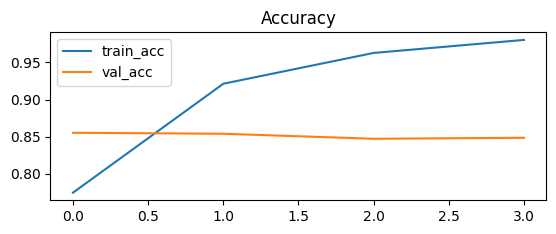

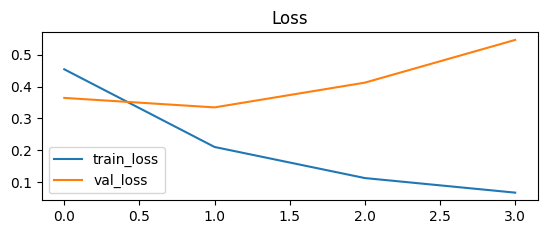

In [17]:
train_accuracy = history_lstm_rnn.history['accuracy']
val_accuracy = history_lstm_rnn.history['val_accuracy']
train_loss = history_lstm_rnn.history['loss']
val_loss = history_lstm_rnn.history['val_loss']
epochs = range(4)

plt.subplot(2,1,1)
plt.plot(epochs,train_accuracy)
plt.plot(epochs,val_accuracy)
plt.legend(['train_acc','val_acc'])
plt.title('Accuracy')
plt.show()

plt.subplot(2,1,2)
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.legend(['train_loss','val_loss'])
plt.title('Loss')
plt.show()

In [20]:
# Imports
import torch
import torch.nn as nn
from torch.utils import data
import numpy as np
from sklearn.metrics import classification_report
from torch.autograd import Variable
from tensorflow.keras import models
from torch.utils import *

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
embedding_dim = 100
max_len = 16

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

word_index = tokenizer.word_index
vocab_size = len(word_index)
sequence_train = tokenizer.texts_to_sequences(train_texts)
seq_padd_train = pad_sequences(sequence_train,padding='post',truncating='post',maxlen=max_len)

#test
sequence_test = tokenizer.texts_to_sequences(test_texts)
seq_padd_test = pad_sequences(sequence_test,padding='post',truncating='post',maxlen=max_len)

In [22]:
embeddings_index = {};
with open("/content/drive/MyDrive/glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coefs

In [23]:
# creating embedding matrix
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [24]:
bilstm_model_glove100 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len,weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    #return_sequences: will ensure output of first LSTM layer matches next
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
bilstm_model_glove100.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
bilstm_model_glove100.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 16, 100)           2653700   
                                                                 
 bidirectional (Bidirectiona  (None, 16, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
 dropout (Dropout)           (None, 6)                

In [25]:
num_epochs = 10

es1 = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)
model_checkpoint1 = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/lstm_glove_embedded.h5",
    monitor= "val_accuracy",
    verbose= 1,
    save_best_only= True,
    save_weights_only= True,
    save_freq="epoch"
)
history1 = bilstm_model_glove100.fit(seq_padd_train, train_labels , batch_size=32, epochs=num_epochs, validation_data=(seq_padd_test,test_labels), callbacks=[es1, model_checkpoint1])

Epoch 1/10
668/668 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.7639
Epoch 1: val_accuracy improved from -inf to 0.82890, saving model to /content/drive/MyDrive/lstm_glove_embedded.h5
668/668 [==============================] - 47s 53ms/step - loss: 0.5036 - accuracy: 0.7639 - val_loss: 0.3964 - val_accuracy: 0.8289
Epoch 2/10
667/668 [============================>.] - ETA: 0s - loss: 0.3893 - accuracy: 0.8412
Epoch 2: val_accuracy improved from 0.82890 to 0.84800, saving model to /content/drive/MyDrive/lstm_glove_embedded.h5
668/668 [==============================] - 32s 48ms/step - loss: 0.3894 - accuracy: 0.8411 - val_loss: 0.3433 - val_accuracy: 0.8480
Epoch 3/10
667/668 [============================>.] - ETA: 0s - loss: 0.3292 - accuracy: 0.8714
Epoch 3: val_accuracy did not improve from 0.84800
668/668 [==============================] - 31s 47ms/step - loss: 0.3291 - accuracy: 0.8714 - val_loss: 0.3598 - val_accuracy: 0.8317
Epoch 4/10
667/668 [=========

In [25]:
bilstm_model_glove100.load_weights(filepath="/content/drive/MyDrive/lstm_glove_embedded.h5")
output1= bilstm_model_glove100.predict(seq_padd_test).round()

r = sklearn.metrics.confusion_matrix(test_labels, output1.round())
accuracy = accuracy_score(test_labels, output1)
report = classification_report(test_labels, output1)

print(r)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

167/167 [==============================] - 2s 4ms/step
[[2738  258]
 [ 422 1924]]
Accuracy: 0.8727068513665294
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2996
           1       0.88      0.82      0.85      2346

    accuracy                           0.87      5342
   macro avg       0.87      0.87      0.87      5342
weighted avg       0.87      0.87      0.87      5342



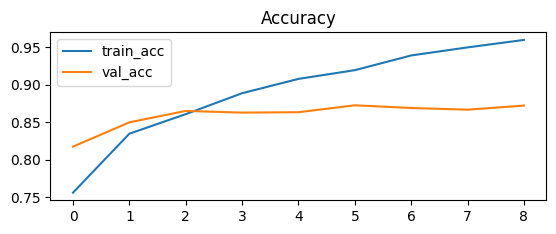

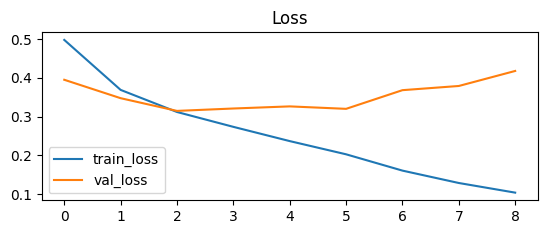

In [27]:
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(9)

plt.subplot(2,1,1)
plt.plot(epochs,train_accuracy)
plt.plot(epochs,val_accuracy)
plt.legend(['train_acc','val_acc'])
plt.title('Accuracy')
plt.show()

plt.subplot(2,1,2)
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.legend(['train_loss','val_loss'])
plt.title('Loss')
plt.show()

In [ ]:
# Gensim bidirectional LSTM + GRU model WITH Word2vec embedding model

In [26]:
import gensim
words = []
for i in df.headline.values:
    words.append(i.split())

#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

len(w2v_model.wv.index_to_key)
#We have now represented each of 38071 words by a 100dim vector.

36599

In [28]:
tokenizer = Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen = 20)

vocab_size = len(tokenizer.word_index) + 1

def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

embedding_vectors_w2v = get_weight_matrix(w2v_model, tokenizer.word_index)

In [29]:
#Defining Neural Network
from tensorflow.keras.layers import Bidirectional, GRU
bilstmgru_model = Sequential()
#Non-trainable embeddidng layer
bilstmgru_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors_w2v], input_length=20, trainable=True))
#LSTM 
bilstmgru_model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
bilstmgru_model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
bilstmgru_model.add(Dense(1, activation='sigmoid'))
bilstmgru_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors_w2v

bilstmgru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 200)           7320000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 256)          336896    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,712,641
Trainable params: 7,712,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.config.run_functions_eagerly(True)
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.2 , random_state = 42) 
#history3 = bilstmgru_model.fit(x_train, y_train, batch_size = 64 , validation_data = (x_test,y_test) , epochs = 5)

In [51]:
es3 = EarlyStopping(monitor="val_acc", mode="max", patience=3)
model_checkpoint3 = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/lstm_w2v_embedded2.h5",
    monitor= "val_acc",
    verbose= 1,
    save_best_only= True,
    save_weights_only= True,
    save_freq="epoch"
)
history3 = bilstmgru_model.fit(x_train, y_train, batch_size = 64 , validation_data = (x_test,y_test) , epochs = 2, callbacks=[es3, model_checkpoint3])

Epoch 1/2
334/334 [==============================] - ETA: 0s - loss: 0.4547 - acc: 0.7712
Epoch 1: val_acc improved from -inf to 0.87158, saving model to /content/drive/MyDrive/lstm_w2v_embedded2.h5
334/334 [==============================] - 537s 2s/step - loss: 0.4547 - acc: 0.7712 - val_loss: 0.3053 - val_acc: 0.8716
Epoch 2/2
334/334 [==============================] - ETA: 0s - loss: 0.1566 - acc: 0.9407
Epoch 2: val_acc did not improve from 0.87158
334/334 [==============================] - 565s 2s/step - loss: 0.1566 - acc: 0.9407 - val_loss: 0.3507 - val_acc: 0.8600


In [35]:
bilstmgru_model.load_weights(filepath="/content/drive/MyDrive/lstm_w2v_embedded2.h5")
output3= bilstmgru_model.predict(x_test).round()

r = sklearn.metrics.confusion_matrix(y_test, output3)
accuracy = accuracy_score(y_test, output3)
report = classification_report(y_test, output3)

print(r)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


167/167 [==============================] - 120s 720ms/step
[[2701  295]
 [ 391 1955]]
Accuracy: 0.8715836765256458
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2996
           1       0.87      0.83      0.85      2346

    accuracy                           0.87      5342
   macro avg       0.87      0.87      0.87      5342
weighted avg       0.87      0.87      0.87      5342



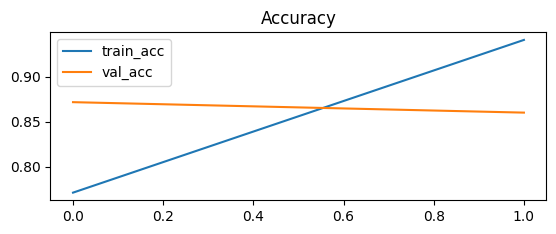

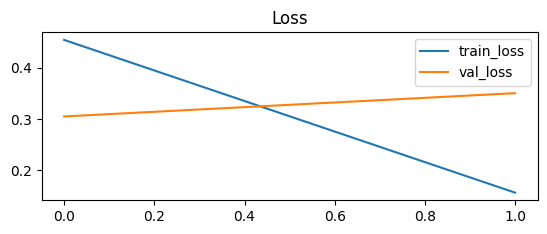

In [77]:
train_accuracy = history3.history['acc']
val_accuracy = history3.history['val_acc']
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(2)

plt.subplot(2,1,1)
plt.plot(epochs,train_accuracy)
plt.plot(epochs,val_accuracy)
plt.legend(['train_acc','val_acc'])
plt.title('Accuracy')
plt.show()

plt.subplot(2,1,2)
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.legend(['train_loss','val_loss'])
plt.title('Loss')
plt.show()

In [56]:
# Naive Bayes

import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download("punkt")
nltk.download("stopwords")

from nltk.corpus import stopwords
import string

def rem_non_ascii(data):
  stripped = (c for c in data if 0 < ord(c) < 127) 
  return ''.join(stripped)

#Lemmatisation
lemmatizer = WordNetLemmatizer()

def nltk2wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:          
    return None
  
def lemmatize_sentence(text):
  nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
  wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
  res_words = []
  for word, tag in wn_tagged:
    if tag is None:            
      res_words.append(word)
    else:
      res_words.append(lemmatizer.lemmatize(word, tag))
  return " ".join(res_words)

print(df.headline[1])


#Definition to remove punctuation 
def remove_features(data_str): # compile regex
    punc_re = re.compile('[%s]' % re.escape(string.punctuation)) 
    num_re = re.compile('(\d+)')
    #mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    #data_str = url_re.sub(' ', data_str)
    # remove @mentions
    #data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 1 characters 
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = word 
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 1:
                cleaned_str = cleaned_str + ' ' + word 
            else:
                cleaned_str += ' '
        list_pos += 1
    
    return " ".join(cleaned_str.split())

# Removing stop words
def remove_stops(data_str):
    # expects a string
    stops = set(stopwords.words("english"))
    list_pos = 0
    cleaned_str = ''
    text = data_str.split()
    for word in text:
        if word not in stops:
            # rebuild cleaned_str
            if list_pos == 0:
                cleaned_str = word
            else:
                cleaned_str = cleaned_str + ' ' + word
            list_pos += 1
    return cleaned_str

#Applying functions for cleaning data in the headline column of dataset

data = []
for i in range(len(df.headline)):
  res = remove_features(df.headline[i])
  res1 = rem_non_ascii(res)
  res2 = remove_stops(res1)
  res3 = lemmatize_sentence(res2)
  data.append(res3)
  
df['clean_headline'] = data

allWords_df = df['clean_headline'].str.split(expand = True).unstack().value_counts()
allWords_df = pd.DataFrame(allWords_df).reset_index()

#Total number of words used
df['nb_words'] = df.headline.apply(lambda x:len(x.split()))

#Number of unique words
df['nb_unique_words'] = df.headline.apply(lambda x: len(set(x.split())))

#Total number of characters used
df['nb_char'] = df.headline.apply(lambda x:len(x))

#Total number of unique characters used
df['nb_unique_char'] = df.clean_headline.apply(lambda x:len(set(x.split())))

#Total number of punctuation used

import string

def num_punc(text):
  x =0
  for i in text.split():
     if i in list(string.punctuation):
       x = x+1 
  return x

df['nb_puctuation'] = df.headline.apply(lambda x: num_punc(x))

import nltk, os, re
from nltk.corpus import stopwords
stopset = stopwords.words('english')

def num_stpwrds(text):
  x=0 
  for i in text.split():
    if i in stopset:
      x =x+1
  return x

df['nb_stpwrds'] = df.headline.apply(lambda x: num_stpwrds(x))

# Average length of words
def length(text):
  return(np.mean([len(w) for w in text.split()]))

df['nb_len_wrd'] = df.headline.apply(lambda x:length(x))

#Number of most frequent words
tokens = nltk.word_tokenize(''.join(df.headline))
frequent = nltk.FreqDist(tokens)
frequent.most_common(15)

#Removing stopwords and punctuation
stopword = stopwords.words('english')

for sym in string.punctuation:
    del frequent[sym]
    
for word in stopword:
    del frequent[word]
    
frequent.most_common(15)

## NUMBER OF WORDS CONTAIN OUT OF MOST COMMON 100 WORDS 
freq_words = list(dict(frequent.most_common()[:100]).keys())

def freq(text):
    return(len([w for w in text.split() if w in freq_words]))
df['nb_freq_words'] = df.headline.apply(lambda x: freq(x))

## AVERAGE OF FREQ TERMS WITH TOTAL WORDS USED
def freq(text):
    return(len([w for w in text.split() if w in freq_words])/len(text.split()))

df['avg_freq_word'] = df.headline.apply(lambda x: freq(x))
df.head(5)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


the 'roseanne' revival catches up to our thorny political mood, for better and worse


,article_link,headline,is_sarcastic,clean_headline,nb_words,nb_unique_words,nb_char,nb_unique_char,nb_puctuation,nb_stpwrds,nb_len_wrd,nb_freq_words,avg_freq_word
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sue secret black co...,12,12,78,10,0,2,5.583333,0,0.000000
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catch thorny political mood w...,14,14,84,8,0,6,5.071429,0,0.000000
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom start fear son web series closest thing gr...,14,13,79,9,0,5,4.714286,0,0.000000
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner want wife listen come alternative debt...,13,13,84,9,0,5,5.538462,1,0.076923
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,rowling wish snape happy birthday magical way,11,11,64,7,0,3,4.909091,1,0.090909


In [57]:
label_y = df.is_sarcastic
df_clean = df.drop('is_sarcastic',axis=1)
seed = 555
X_train, X_test, y_train, y_test = train_test_split(df_clean, label_y, test_size=0.3, random_state=seed)

df_1 = X_train.drop(['article_link','headline','clean_headline'],axis=1)
df_1.head()

,nb_words,nb_unique_words,nb_char,nb_unique_char,nb_puctuation,nb_stpwrds,nb_len_wrd,nb_freq_words,avg_freq_word
16409,6,6,40,5,0,1,5.833333,1,0.166667
18289,11,11,75,9,0,4,5.909091,2,0.181818
13710,10,10,62,9,0,1,5.300000,1,0.100000
9945,8,8,62,7,0,1,6.875000,1,0.125000
14562,11,11,73,8,0,2,5.727273,1,0.090909


In [58]:
df_2 = X_train.loc[:,'clean_headline']
df_2.head()

16409                        arby regional manager work do
18289    mccain blast obama touch burma shave style bil...
13710    aquarium touch tank let kid pet water natural ...
9945     national essay write contest accept video subm...
14562    trump accuser call congress investigate sexual...
Name: clean_headline, dtype: object

In [59]:
seed = 666
X_train_txt, X_val_txt, y_train_txt, y_val_txt = train_test_split(df_2, y_train, test_size=0.2, random_state=seed)
print("X_train_txt shape:", X_train_txt.shape, "y_train_txt shape:", y_train_txt.shape)
print("X_val_txt shape:", X_val_txt.shape, "y_val_txt shape:", y_val_txt.shape)

X_train_txt shape: (14956,) y_train_txt shape: (14956,)
X_val_txt shape: (3740,) y_val_txt shape: (3740,)


In [60]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import BernoulliNB

text_clf = Pipeline([('vect', CountVectorizer()),('tfidf',TfidfTransformer()),('clf',BernoulliNB())])

text_clf.fit(X_train_txt,y_train_txt)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', BernoulliNB())])

In [61]:
predict_text_val = text_clf.predict(X_val_txt)
np.mean(predict_text_val == y_val_txt) 

0.7847593582887701

In [63]:
from sklearn.metrics import confusion_matrix
results_nb = confusion_matrix(y_val_txt, predict_text_val) 
print("Confusion Matrix :")
print(results_nb) 
print ("Accuracy Score :",accuracy_score(y_val_txt, predict_text_val))
print ("Report : ")
print (classification_report(y_val_txt, predict_text_val))

Confusion Matrix :
[[1815  247]
 [ 558 1120]]
Accuracy Score : 0.7847593582887701
Report : 
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      2062
           1       0.82      0.67      0.74      1678

    accuracy                           0.78      3740
   macro avg       0.79      0.77      0.78      3740
weighted avg       0.79      0.78      0.78      3740



Asking ChatGPT for a sarcastic news headline.
"Wow, World Still Spinning Despite All Your Problems, Experts Say"


In [6]:
def run_model1(gpt_text):
  # Preprocess the user input
  preprocessed_input = re.sub(r'\W', ' ', completion.choices[0].message.content.lower())

  # Vectorize the user input
  user_vector = vectorizer.transform([preprocessed_input])

  # Predict the sarcasm label for the user input
  prediction = classifier.predict(user_vector)

  # Map the label to the corresponding class
  if prediction[0] == 0:
      result = "non-sarcastic"
  else:
      result = "sarcastic"

  # Print the predicted label
  print("Logistic Regression says the text is predicted as", result)

In [39]:
max_sequence_length

40

In [41]:
def run_model2(gpt_text):
  lstm_model.load_weights(filepath="/content/drive/MyDrive/lstm-rnn.h5")
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train_texts)

  test_sequences = tokenizer.texts_to_sequences(gpt_text.lower())
  test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')
  output= lstm_model.predict(test_sequences).round()

  if output[0] == 1:
    print("LSTM-RNN Model says the text is predicted as sarcastic")
  else:
    print("LSTM-RNN Model says the text is predicted as Not sarcastic")

In [31]:
def run_model3(gpt_text):
  embedding_dim = 100
  max_len = 16
  tokenizer = Tokenizer(oov_token="<OOV>")
  tokenizer.fit_on_texts(train_texts)
  word_index = tokenizer.word_index
  vocab_size = len(word_index)
  #test
  sequence_test = tokenizer.texts_to_sequences(gpt_text.lower())
  seq_padd_test = pad_sequences(sequence_test,padding='post',truncating='post',maxlen=max_len)
  
  bilstm_model_glove100.load_weights(filepath="/content/drive/MyDrive/lstm_glove_embedded.h5")
  output1= bilstm_model_glove100.predict(seq_padd_test).round()
  if output1[0] == 1:
    print("LSTM Model with Glove Embeddinigs says the text is predicted as sarcastic")
  else:
    print("LSTM Model with Glove Embeddinigs says the text is predicted as not sarcastic")

In [43]:
def run_model4(gpt_text):
  bilstmgru_model.load_weights(filepath="/content/drive/MyDrive/lstm_w2v_embedded2.h5")
  output3= bilstmgru_model.predict(x_test).round()

  if output3[0] == 1:
    print("LSTM-RNN with Word2vec embddings Model says the text is predicted as sarcastic")
  else:
    print("LSTM-RNN with Word2vec embddings Model says the text is predicted as Not sarcastic")

In [ ]:
# Calling chatGPT API to validate models.

In [4]:
# Keep sarcasm = 1 to generate a sarcastic news headline from ChatGPT. Keep sarcasm = 0 for a real non-sarcastic news headline.

sarcasm = 1

In [44]:
#!pip install openai
import os
import openai

openai.api_key = "INSERT_API_KEY_HERE"

if (sarcasm == 1):
    message = "Asking ChatGPT for a sarcastic news headline."
    print(message)
else:
    message = "Asking ChatGPT for a non-sarcastic news headline."
    print(message)# Your code here

completion = openai.ChatCompletion.create(model="gpt-3.5-turbo",messages=[{"role": "user", "content": message}])
print(completion.choices[0].message.content)

run_model1(completion.choices[0].message.content)
run_model2(completion.choices[0].message.content)
run_model3(completion.choices[0].message.content)
run_model4(completion.choices[0].message.content)


Asking ChatGPT for a sarcastic news headline.
"Breaking News: Local Politician Successfully Completes Full Sentence Without Any Scandals!"
Logistic Regression says the text is predicted as sarcastic
3/3 [==============================] - 0s 82ms/step
LSTM-RNN Model says the text is predicted as sarcastic
3/3 [==============================] - 0s 125ms/step
LSTM Model with Glove Embeddinigs says the text is predicted as not sarcastic
167/167 [==============================] - 115s 688ms/step
LSTM-RNN with Word2vec embddings Model says the text is predicted as sarcastic
